# Whale Classification Model
This notebook describes the strategy behind the 0.78563 submission to the Humpack Whale identification Challenge.

It should be studied in conjunction with the [Bounding Box Model](http://www.kaggle.com/martinpiotte/bounding-box-model) notebook which describes separately the strategy for image cropping.

To speed things up, the results of some slow computations are included as a dataset instead of being recomputed here. However, the code is still provided in the notebook as reference, even if it is not executed by default.

# Abstract
The approach used for this submission is essentially a [Siamese Neural Network](http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf), with a few modifications that will be covered in details later. The element that generated the largest accuracy improvement is the procedure used to generate image pairs during training. Each training epoch is composed of a sequence of image pairs (A, B) such that:

* Exactly 50% of the pairs are for matching whales, and 50% for different whales;
* Each image from the training set is used exactly 4 times per epoch: A and B images of matching whales, A and B images of different whale pairs;
* Pairs of images of different whales are selected to be difficult for the network to distinguish at a given stage of the training. This is inspired from adversarial training: find pairs of images that are from different whales, but that are still very similar from the model perspective.

Implementing this strategy while training a Siamese Neural Network is what makes the largest contribution to the model accuracy. Other details contribute somewhat to the accuracy, but have a much smaller impact.

# Overview
This notebook describes all the different elements of the submission. Obviously, to cover everything, it has to be fairly long. I encourage everyone to skip ahead directly  to whatever you are most interested in, without  necessarily going through everything.
## Content
1. Duplicate image identification (not much to see here -- keep moving)
1. Image preprocessing (just the regular stuff)
1. Siamese Neural Network architecture (some interesting thoughts)
1. Training data construction (most of the secret sauce is here)
1. Training procedure (zzzzz.....)
1. Generating the submission file (re-zzzzz.....)
1. Bootstrapping and ensemble (classic but short)
1. Visualization (everyone's favorite!)
1. Off topic (why add this unless it is interesting?)

# Duplicate image identification
This section describes the heuristic used to identify duplicate images. The fact that the training and test set have duplicate images has already been well documented. Some images are perfect binary copies, while other have been altered somewhat: contrast and brightness, size, masking the legend, etc. 

Two images are considered duplicate if they meet the following criteria:

1. Both images have the same [Perceptual Hash](http://www.phash.org/) (phash); or
1. Both images have:
    1. phash that differ by at most 6 bits, and;
    1. have the same size, and;
    1. the pixelwise mean square error between the normalized images is below a given threshold.

The *p2h* dictionary associate a unique image id (phash) for each picture. The *h2p* dictionary associate each unique image id to the prefered image to be used for this hash.

The prefered image is the one with the highest resolution, or any one if they have the same resolution.

In [1]:
# Read the dataset description
from pandas import read_csv

tagged = dict([(p,w) for _,p,w in read_csv('./whale-categorization-playground/train.csv').to_records()])
submit = [p for _,p,_ in read_csv('./whale-categorization-playground/sample_submission.csv').to_records()]
join   = list(tagged.keys()) + submit
len(tagged),len(submit),len(join),list(tagged.items())[:5],submit[:5]

(9850,
 15610,
 25460,
 [('00022e1a.jpg', 'w_e15442c'),
  ('000466c4.jpg', 'w_1287fbc'),
  ('00087b01.jpg', 'w_da2efe0'),
  ('001296d5.jpg', 'w_19e5482'),
  ('0014cfdf.jpg', 'w_f22f3e3')],
 ['00029b3a.jpg',
  '0003c693.jpg',
  '000bc353.jpg',
  '0010a672.jpg',
  '00119c3f.jpg'])

In [2]:
# Determise the size of each image
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

def expand_path(p):
    if isfile('./whale-categorization-playground/train/' + p): return './whale-categorization-playground/train/' + p
    if isfile('./whale-categorization-playground/test/' + p): return './whale-categorization-playground/test/' + p
    return p

p2size = {}
for p in tqdm_notebook(join):
    size      = pil_image.open(expand_path(p)).size
    p2size[p] = size
len(p2size), list(p2size.items())[:5]

(25460,
 [('00022e1a.jpg', (699, 500)),
  ('000466c4.jpg', (1050, 700)),
  ('00087b01.jpg', (1050, 368)),
  ('001296d5.jpg', (397, 170)),
  ('0014cfdf.jpg', (700, 398))])

In [4]:
pip install ImageHash

    100% |████████████████████████████████| 296kB 3.3MB/s ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Read or generate p2h, a dictionary of image name to image id (picture to hash)
import pickle
import numpy as np
from imagehash import phash
from math import sqrt

# Two phash values are considered duplicate if, for all associated image pairs:
# 1) They have the same mode and size;
# 2) After normalizing the pixel to zero mean and variance 1.0, the mean square error does not exceed 0.1
def match(h1,h2):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 =  pil_image.open(expand_path(p1))
            i2 =  pil_image.open(expand_path(p2))
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1/sqrt((a1**2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2/sqrt((a2**2).mean())
            a  = ((a1 - a2)**2).mean()
            if a > 0.1: return False
    return True

if isfile('./humpback-whale-identification-model-files/p2h.pickle'):
    with open('./humpback-whale-identification-model-files/p2h.pickle', 'rb') as f:
        p2h = pickle.load(f)
else:
    # Compute phash for each image in the training and test set.
    p2h = {}
    for p in tqdm_notebook(join):
        img    = pil_image.open(expand_path(p))
        h      = phash(img)
        p2h[p] = h

    # Find all images associated with a given phash value.
    h2ps = {}
    for p,h in p2h.items():
        if h not in h2ps: h2ps[h] = []
        if p not in h2ps[h]: h2ps[h].append(p)

    # Find all distinct phash values
    hs = list(h2ps.keys())

    # If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
    h2h = {}
    for i,h1 in enumerate(tqdm_notebook(hs)):
        for h2 in hs[:i]:
            if h1-h2 <= 6 and match(h1, h2):
                s1 = str(h1)
                s2 = str(h2)
                if s1 < s2: s1,s2 = s2,s1
                h2h[s1] = s2

    # Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
    for p,h in p2h.items():
        h = str(h)
        if h in h2h: h = h2h[h]
        p2h[p] = h

len(p2h), list(p2h.items())[:5]

(25460,
 [('00022e1a.jpg', 'b362cc79b1a623b8'),
  ('000466c4.jpg', 'b3cccc3331cc8733'),
  ('00087b01.jpg', 'bc4ed0f2a7e168a8'),
  ('001296d5.jpg', '93742d9a28b35b87'),
  ('0014cfdf.jpg', 'd4a1dab1c49f6352')])

In [6]:
# For each image id, determine the list of pictures
h2ps = {}
for p,h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)
# Notice how 25460 images use only 20913 distinct image ids.
len(h2ps),list(h2ps.items())[:5]

(20913,
 [('b362cc79b1a623b8', ['00022e1a.jpg']),
  ('b3cccc3331cc8733', ['000466c4.jpg']),
  ('bc4ed0f2a7e168a8', ['00087b01.jpg', '7c72d707.jpg']),
  ('93742d9a28b35b87', ['001296d5.jpg']),
  ('d4a1dab1c49f6352', ['0014cfdf.jpg', '89c94943.jpg'])])

In [7]:
# Show an example of a duplicate image (from training of test set)
import matplotlib.pyplot as plt

def show_whale(imgs, per_row=2):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

for h, ps in h2ps.items():
    if len(ps) > 2:
        print('Images:', ps)
        imgs = [pil_image.open(expand_path(p)) for p in ps]
        show_whale(imgs, per_row=len(ps))
        break

Images: ['0c35fcb4.jpg', '2d6610b9.jpg', 'a98bfd97.jpg']


In [8]:
# For each images id, select the prefered image
def prefer(ps):
    if len(ps) == 1: return ps[0]
    best_p = ps[0]
    best_s = p2size[best_p]
    for i in range(1, len(ps)):
        p = ps[i]
        s = p2size[p]
        if s[0]*s[1] > best_s[0]*best_s[1]: # Select the image with highest resolution
            best_p = p
            best_s = s
    return best_p

h2p = {}
for h,ps in h2ps.items(): h2p[h] = prefer(ps)
len(h2p),list(h2p.items())[:5]

(20913,
 [('b362cc79b1a623b8', '00022e1a.jpg'),
  ('b3cccc3331cc8733', '000466c4.jpg'),
  ('bc4ed0f2a7e168a8', '00087b01.jpg'),
  ('93742d9a28b35b87', '001296d5.jpg'),
  ('d4a1dab1c49f6352', '0014cfdf.jpg')])

# Image preprocessing
Training is performed on images subjected to the following operations:

1.  Rotate the image if it is in the rotate set;
1. Transform to black and white;
1. Apply an affine transformation .

## Image rotation

I noticed that some pictures have the whale fluke pointing down instead of up as usual. Whenever I encountered such instance in the training set (not in the test set), I would add it to a list. During training, these images are rotated 180 degrees to normalize them with the fluke pointing up. The list is not exhausitve, there are probably more case that I have not noticed.

In [9]:
with open('./humpback-whale-identification-model-files/rotate.txt', 'rt') as f: rotate = f.read().split('\n')[:-1]
rotate = set(rotate)
rotate

{'2b792814.jpg',
 '2bc459eb.jpg',
 '3401bafe.jpg',
 '56fafc52.jpg',
 'a492ab72.jpg',
 'd1502267.jpg',
 'e53d2b96.jpg',
 'ed4f0cd5.jpg',
 'f2ec136c.jpg',
 'f966c073.jpg'}

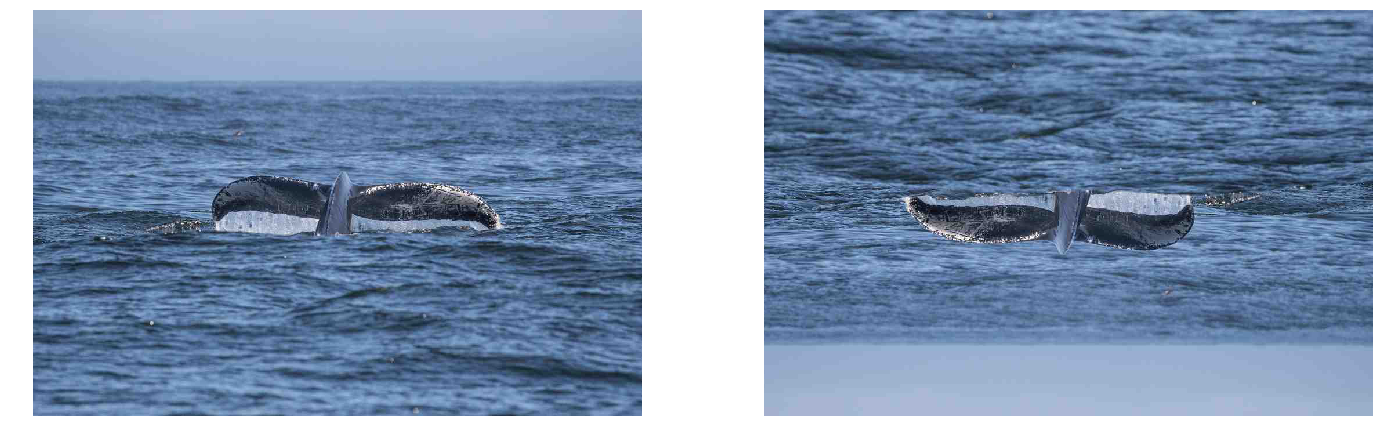

In [10]:
def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    if p in rotate: img = img.rotate(180)
    return img

p    = list(rotate)[0]
imgs = [pil_image.open(expand_path(p)), read_raw_image(p)]
show_whale(imgs)

The left side image is the original image (fluke pointing down). The right side image is rotated 180 degrees.

## Convert to black and white
In my early experiments, I noticed that my models achieved approximately the same accuracy when comparing two colored images, or two black and white images. However, comparing a colored image with a black and white image resulted in much lower accuracy. The simplest solution was to convert all images to black and white, which did not reduce the accuracy even when comparing originally colored images.

## Affine tranformation
The [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) maps a rectangular area of the original image to a square image with resolution 384x384x1 (only one channel for black and white). The rectangular area has a width over height aspect ratio of 2.15, close to the average picture aspect ratio. The rectangle is taken to be slightly larger than the computed [bounding box](https://www.kaggle.com/martinpiotte/bounding-box-model), as computed in the model defined in a separate kernel, The idea is that clipping the edges of the fluke is more harmful than the gain obtained by fitting it exactly, thus a margin is preferred.

During training, data augmentation is performed by adding a random transformation that composes zoom, shift, rotation and shear. The random transform is skipped when testing.

Finally, the image is normalized to zero mean and unit variance.

In [11]:
# Read the bounding box data from the bounding box kernel (see reference above)
with open('./humpback-whale-identification-model-files/bounding-box.pickle', 'rb') as f:
    p2bb = pickle.load(f)
list(p2bb.items())[:5]

[('00022e1a.jpg', (34, 45, 682, 317)),
 ('000466c4.jpg', (263, 309, 591, 412)),
 ('00087b01.jpg', (-6, 2, 1028, 363)),
 ('001296d5.jpg', (9, 21, 387, 135)),
 ('0014cfdf.jpg', (36, 129, 636, 299))]

In [13]:
pip install Keras

    100% |████████████████████████████████| 317kB 4.8MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 5.6MB/s ta 0:00:011
    100% |████████████████████████████████| 51kB 7.4MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install tensorflow

    100% |████████████████████████████████| 73.6MB 175kB/s ta 0:00:011    30% |█████████▊                      | 22.3MB 7.3MB/s eta 0:00:07    45% |██████████████▌                 | 33.3MB 5.0MB/s eta 0:00:09
    100% |████████████████████████████████| 368kB 5.1MB/s ta 0:00:01
    100% |████████████████████████████████| 2.0MB 3.2MB/s ta 0:00:011
    100% |████████████████████████████████| 3.2MB 2.6MB/s ta 0:00:011
    100% |████████████████████████████████| 102kB 4.9MB/s a 0:00:011
    100% |████████████████████████████████| 1.4MB 4.2MB/s ta 0:00:011
    100% |████████████████████████████████| 92kB 11.4MB/s ta 0:00:01
  Stored in directory: /Users/MattWirtz/Library/Caches/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Stored in directory: /Users/MattWirtz/Library/Caches/pip/wheels/ee/98/38/46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
  Stored in directory: /Users/MattWirtz/Library/Caches/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab

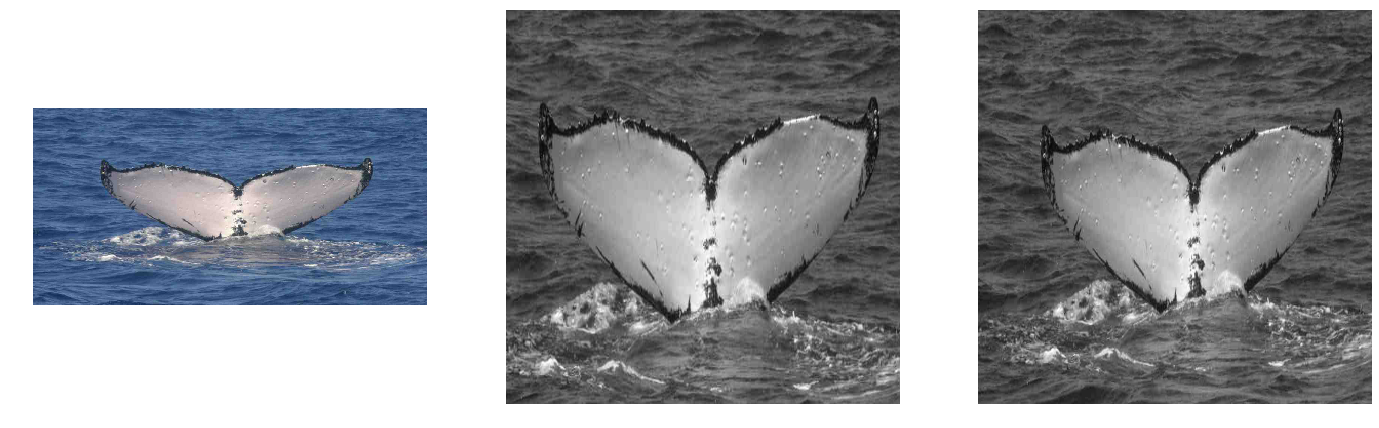

In [16]:
# Suppress annoying stderr output when importing keras.
import sys
import platform
old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')
import keras
sys.stderr = old_stderr

import random
from keras import backend as K
from keras.preprocessing.image import img_to_array,array_to_img
from scipy.ndimage import affine_transform

img_shape    = (384,384,1) # The image shape used by the model
anisotropy   = 2.15 # The horizontal compression ratio
crop_margin  = 0.05 # The margin added around the bounding box to compensate for bounding box inaccuracy

def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    """
    Build a transformation matrix with the specified characteristics.
    """
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

def read_cropped_image(p, augment):
    """
    @param p : the name of the picture to read
    @param augment: True/False if data augmentation should be performed
    @return a numpy array with the transformed image
    """
    # If an image id was given, convert to filename
    if p in h2p: p = h2p[p]
    size_x,size_y = p2size[p]
    
    # Determine the region of the original image we want to capture based on the bounding box.
    x0,y0,x1,y1   = p2bb[p]
    if p in rotate: x0, y0, x1, y1 = size_x - x1, size_y - y1, size_x - x0, size_y - y0
    dx            = x1 - x0
    dy            = y1 - y0
    x0           -= dx*crop_margin
    x1           += dx*crop_margin + 1
    y0           -= dy*crop_margin
    y1           += dy*crop_margin + 1
    if (x0 < 0     ): x0 = 0
    if (x1 > size_x): x1 = size_x
    if (y0 < 0     ): y0 = 0
    if (y1 > size_y): y1 = size_y
    dx            = x1 - x0
    dy            = y1 - y0
    if dx > dy*anisotropy:
        dy  = 0.5*(dx/anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx  = 0.5*(dy*anisotropy - dx)
        x0 -= dx
        x1 += dx

    # Generate the transformation matrix
    trans = np.array([[1, 0, -0.5*img_shape[0]], [0, 1, -0.5*img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0)/img_shape[0], 0, 0], [0, (x1 - x0)/img_shape[1], 0], [0, 0, 1]]), trans)
    if augment:
        trans = np.dot(build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.8, 1.0),
            random.uniform(0.8, 1.0),
            random.uniform(-0.05*(y1 - y0), 0.05*(y1 - y0)),
            random.uniform(-0.05*(x1 - x0), 0.05*(x1 - x0))
            ), trans)
    trans = np.dot(np.array([[1, 0, 0.5*(y1 + y0)], [0, 1, 0.5*(x1 + x0)], [0, 0, 1]]), trans)

    # Read the image, transform to black and white and comvert to numpy array
    img   = read_raw_image(p).convert('L')
    img   = img_to_array(img)
    
    # Apply affine transformation
    matrix = trans[:2,:2]
    offset = trans[:2,2]
    img    = img.reshape(img.shape[:-1])
    img    = affine_transform(img, matrix, offset, output_shape=img_shape[:-1], order=1, mode='constant', cval=np.average(img))
    img    = img.reshape(img_shape)

    # Normalize to zero mean and unit variance
    img  -= np.mean(img, keepdims=True)
    img  /= np.std(img, keepdims=True) + K.epsilon()
    return img

def read_for_training(p):
    """
    Read and preprocess an image with data augmentation (random transform).
    """
    return read_cropped_image(p, True)

def read_for_validation(p):
    """
    Read and preprocess an image without data augmentation (use for testing).
    """
    return read_cropped_image(p, False)

p = list(tagged.keys())[312]
imgs = [
    read_raw_image(p),
    array_to_img(read_for_validation(p)),
    array_to_img(read_for_training(p))
]
show_whale(imgs, per_row=3)

The left image is the original picture. The center image does the test transformation. The right image adds a random data augmentation transformation.

# Siamese Neural Network architecture
The Siamese Neural Network compares two images and decides if the two images are taken from the same whale, or different whales. By testing each image from the test set against every image from the training set, the most likely whales can be identified by sorting the pictures in likelihood for a match.

A Siamese Neural Network is composed of two parts. A Convolutation Neural Network (CNN) transforms an input image into a vector of features describing the whale. The same CNN, with the same weights, is used for both images. I call the CNN the __branch model__. I used a custom model mostly inspired from [ResNet](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf).

What I call the __head model__ is used to compare the feature vectors from the CNN and decide if the whales match or not.

## Head model
The head model compares the feature vector from the branch model to decide if the pictures show the same or different whales.  The typical approach is to use a distance measure (e.g. \\( L_1 \\)) with a contrastive loss function, but there are a few reasons to try something different:

* A distance measure will consider two features with value zero as a perfect match, while two features with large but slightly different values will be seen as good, but not quite as good since they are not exactly equal. Still, I feel there is more postive signal in the active features than in the negative ones, especially with ReLU (Rectified Linear Unit) activation, concept that is lost by the distance measure.
* Also, a distance measure does not provide for features to be negatively correlated. Consider a case where, if both images have feature X, they must be the same whale, unless they also both have feature Y, in which case X is not as clear.
* At the same time, there is this implicit assumption that swapping the two images must produce the same result: if A is the same whale as B, B must be the same whale as A. 

To address these concerns, i proceed as follow:

1. For each feature I compute the sum, the product, the absolute difference and the difference squared (\\(x + y, x y, |x - y|, (x - y)^2\\)).
1. The four values are passed through a small neural network, which can learn how to weigh between matching zeros and close non-zero values. The same neural net with the same weights is used for each feature.
1. The output is a weighted sum of the converted features, with a sigmoid activation. The value of the weight is redundant, because the weight is just a scaling factor of the feature, which could be learned by another layer, however, it allows for negative weights, which cannot be produced otherwise when using ReLU activation.

## Branch model
The branch model is a regular CNN model. Here are the key elements of its design:
* Because the training dataset is small, I tried to keep the number of learned parameter relatively small, while keeping the model expressive enough. A ResNet like architecture is more economical than a [VGG](https://arxiv.org/abs/1409.1556) like network for example.
* The problem turned out to be memory bound, with most memory being taken to store activations from the feedforward pass, used to compute the gradient during backpropagation. With Windows 10 and a GTX 1080 card, there is about 6.8GB VRAM available, and this limit has constrained the model choice. 

The branch model is composed of 6 blocks, each block processing maps with smaller and smaller resolution,, with intermediate pooling layers.

* Block 1 - 384x384
* Block 2 - 96x96
* Block 3 - 48x48
* Block 4 - 24x24
* Block 5 - 12x12
* Block 6 - 6x6

Block 1 has a single convolution layer with stride 2 followed by 2x2 max pooling. Because of the high resolution, it uses a lot of memory, so a minimum of work is done here to save memory for subsequent blocks.

Block 2 has two 3x3 convolutions similar to VGG. These convolutions are less memory intensive then the subsequent ResNet blocks, and are used to save memory. Note that after this, the tensor has dimension 96x96x64, the same volume as the initial 384x384x1 image, thus we can assume no significant information has been lost.

Blocks 3 to 6 perform ResNet like convolution. I suggest reading the original paper, but the idea is to form a subblock with a 1x1 convolution reducing the number of features, a 3x3 convolution and another 1x1 convolution to restore the number of features to the original. The output of these convolutions is then added to the original tensor (bypass connection). I use 4 such subblocks by block, plus a single 1x1 convolution to increase the feature count after each pooling layer.

The final step of the branch model is a global max pooling, which makes the model robust to fluke not being always well centered.

## Code
The following is the Keras code for the model.

In [21]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [22]:
from keras import regularizers
from keras.optimizers import Adam
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, Lambda, MaxPooling2D, Reshape
from keras.models import Model

def subblock(x, filter, **kwargs):
    x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y) # Reduce the number of features to 'filter'
    y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y) # Extend the feature field
    y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y) # no activation # Restore the number of original features
    y = Add()([x,y]) # Add the bypass connection
    y = Activation('relu')(y)
    return y

def build_model(lr, l2, activation='sigmoid'):

    ##############
    # BRANCH MODEL
    ##############
    regul  = regularizers.l2(l2)
    optim  = Adam(lr=lr)
    kwargs = {'padding':'same', 'kernel_regularizer':regul}

    inp = Input(shape=img_shape) # 384x384x1
    x   = Conv2D(64, (9,9), strides=2, activation='relu', **kwargs)(inp)

    x   = MaxPooling2D((2, 2), strides=(2, 2))(x) # 96x96x64
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3,3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 48x48x64
    x = BatchNormalization()(x)
    x = Conv2D(128, (1,1), activation='relu', **kwargs)(x) # 48x48x128
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 24x24x128
    x = BatchNormalization()(x)
    x = Conv2D(256, (1,1), activation='relu', **kwargs)(x) # 24x24x256
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 12x12x256
    x = BatchNormalization()(x)
    x = Conv2D(384, (1,1), activation='relu', **kwargs)(x) # 12x12x384
    for _ in range(4): x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 6x6x384
    x = BatchNormalization()(x)
    x = Conv2D(512, (1,1), activation='relu', **kwargs)(x) # 6x6x512
    for _ in range(4): x = subblock(x, 128, **kwargs)
    
    x             = GlobalMaxPooling2D()(x) # 512
    branch_model  = Model(inp, x)
    
    ############
    # HEAD MODEL
    ############
    mid        = 32
    xa_inp     = Input(shape=branch_model.output_shape[1:])
    xb_inp     = Input(shape=branch_model.output_shape[1:])
    x1         = Lambda(lambda x : x[0]*x[1])([xa_inp, xb_inp])
    x2         = Lambda(lambda x : x[0] + x[1])([xa_inp, xb_inp])
    x3         = Lambda(lambda x : K.abs(x[0] - x[1]))([xa_inp, xb_inp])
    x4         = Lambda(lambda x : K.square(x))(x3)
    x          = Concatenate()([x1, x2, x3, x4])
    x          = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    # Per feature NN with shared weight is implemented using CONV2D with appropriate stride.
    x          = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
    x          = Reshape((branch_model.output_shape[1], mid, 1))(x)
    x          = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
    x          = Flatten(name='flatten')(x)
    
    # Weighted sum implemented as a Dense layer.
    x          = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')

    ########################
    # SIAMESE NEURAL NETWORK
    ########################
    # Complete model is constructed by calling the branch model on each input image,
    # and then the head model on the resulting 512-vectors.
    img_a      = Input(shape=img_shape)
    img_b      = Input(shape=img_shape)
    xa         = branch_model(img_a)
    xb         = branch_model(img_b)
    x          = head_model([xa, xb])
    model      = Model([img_a, img_b], x)
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model

model, branch_model, head_model = build_model(64e-5,0)
head_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 512)          0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 512)          0           input_7[0][0]                    
          

In [ ]:
from keras.utils import plot_model
import pydot
plot_model(head_model, to_file='head-model.png')
pil_image.open('head-model.png')

In [20]:
branch_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 64) 5248        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 96, 96, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 64)   256         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
# Oops, this is HUGE!
plot_model(branch_model, to_file='branch-model.png')
img = pil_image.open('branch-model.png')
img.resize([x//2 for x in img.size])

# Training data construction
As highlighted in the abstract section, this is the part that makes a big difference in the model accuracy.

We want the Siamese Neural Network to pick the one correct whale from all the possible whales from the training set. While scoring the correct whale high, it must simultaneously score **all** other whales lower. It is not enough to have a random whale score low. To force all the other whales to a low probability, the training algorithm presents pairs of pictures with increasing difficulty, as evaluated by the model at any given time. Essentially, we forcus the training on pairs that he model is getting wrong, as a form of adversarial training.

At the same time, we want the model to recognize **whales** and not **pictures**. Given the small number of pictures in the training dataset, it is not irrealistic to imagine the model recognizing a specific picture using the shape of a wave, or a bird flying by. To prevent this, the data presented to the model must be unbiased. If a picture is used more often in negative examples, the model risks simply learning to guess a mismatch whenever this picture is present, without learning how to compare the whales correctly. By presenting each image an equal number of times, with 50% positive and 50% negative examples, the model has no incentive in learning to recognize specific pictures, and thus focuses on recognizing whales as desired.

## Image selection
To begin, we reduce the number of images from the training set:

* Images from the blacklist are removed;
* Duplicate images are removed;
* All 'new_whale' images are removed;
* All whales with a single image are removed.

The blacklist was constructed manually by spotting images unhelpful to training. Reasons could be the underside of the fluke is not visible, or we see only dead fluke fragments on the a beach, there are two whales in the picture, etc. The list is in no way exhaustive.

In [26]:
with open('./humpback-whale-identification-model-files/exclude.txt', 'rt') as f: exclude = f.read().split('\n')[:-1]   
len(exclude)

34

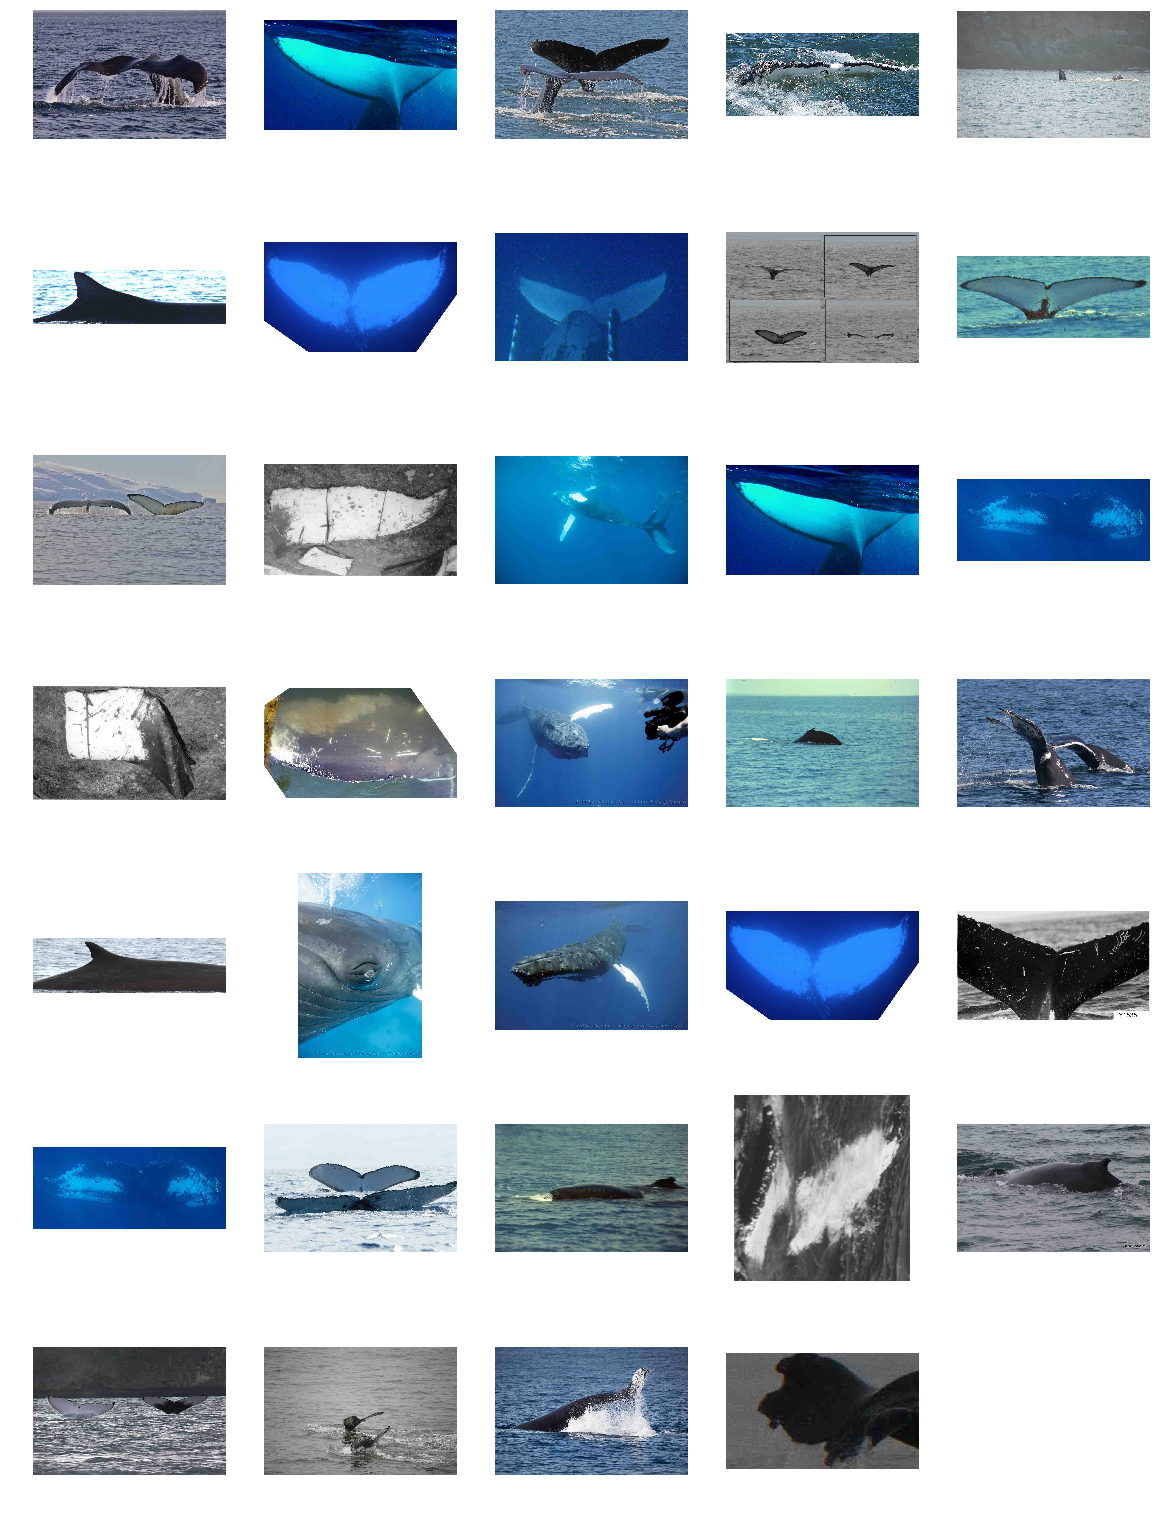

In [27]:
show_whale([read_raw_image(p) for p in exclude], per_row=5)

## Matching whale examples
Half the examples used during training are for pair of images. For each whale of the training set, compute a [derangement](https://en.wikipedia.org/wiki/Derangement) of its pictures. Use the original order as picture A, and the derangment as picture B. This creates a random number of matching image pairs, with each image taken exactly two times.

## Different whales examples

Different whales examples are generated by computing a derangement of all pictures from the training set, subject to:

* The image pairs must belong to different whales;
* The pairs formed must be difficult for the model to distinguish.

The following algorith is used to generate the pairs:

1. The similarity between each pair of image is computed using the current model state. This has complexity \\( \frac {n(n-1)} 2  \\), where n is the size of the training set. Fortunately, only the head model must be computed for all pairs, and it is very fast. The 512-feature vectors can be pre-computed once for each image, i.e. O(n) complexity.
1. Entry that correpond to pair of images from the same whale are set with similarity \\( -\infty \\).
1. [Linear sum assignment](https://en.wikipedia.org/wiki/Assignment_problem) algorithm is used to find the most difficult matching. 
1. To randomize the selection, and control the matching difficulty, we add a random matrix to the cost matrix from step #1 . The random matrix has values uniformly distributed between 0 and K. The larger K, the more random the matching. The smaller K, the more difficult the pairing is for the model.
1. To produce different matching for successive epochs, the selected entries in the matrix are overwritten with \\( -\infty \\) to force an alternate selection for the next matching.

## Code
The described logic is essentially implemented by the TrainingData class, that performs just in time data augmentation as well as computing the matching.

In [28]:
# Find all the whales associated with an image id. It can be ambiguous as duplicate images may have different whale ids.
h2ws = {}
new_whale = 'new_whale'
for p,w in tagged.items():
    if w != new_whale: # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h,ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)
len(h2ws)

8412

In [29]:
# For each whale, find the unambiguous images ids.
w2hs = {}
for h,ws in h2ws.items():
    if len(ws) == 1: # Use only unambiguous pictures
        if h2p[h] in exclude:
            print(h) # Skip excluded images
        else:
            w = ws[0]
            if w not in w2hs: w2hs[w] = []
            if h not in w2hs[w]: w2hs[w].append(h)
for w,hs in w2hs.items():
    if len(hs) > 1:
        w2hs[w] = sorted(hs)
len(w2hs)

ebf094854a2bb1d6
f86bcf9487653848
d931c4768ebf9098
807b19b6766d09ce
bc984f67a31b48a6
aa557d0ad40f807f
c5313ec3c0343bcf
9dc39bb4833cc3c8
fb8c85f18c67131c
afa994d4416b2ab6
c0352f2194b7fcca
c4cc196f46bc8cce
c0c0753e9fcf4368
e5d11a1e86c47979
cdc0363cc23c3ecb
d8dc91b13fae8a18
f3ad8c8cb2b38c8c
f18c966fb836c90c
f8908e4ee223f758
a2d5d5eae64f2a01
96c949b632e90d3e
88d1a0eee07ce9da
e8d1960f60b13fca
d08f9d61729e8d61
90376cc843f6b9a3
e92d90d2616f0f9c
c96d1296e96b16b4
c7882c3359ec7327
9467679c9b638c98
f43183739a8f53c4


4239

In [30]:
# Find the list of training images, keep only whales with at least two images.
train = [] # A list of training image ids
for hs in w2hs.values():
    if len(hs) > 1:
        train += hs
random.shuffle(train)
train_set = set(train)

w2ts = {} # Associate the image ids from train to each whale id.
for w,hs in w2hs.items():
    for h in hs:
        if h in train_set:
            if w not in w2ts: w2ts[w] = []
            if h not in w2ts[w]: w2ts[w].append(h)
for w,ts in w2ts.items(): w2ts[w] = np.array(ts)
    
t2i = {} # The position in train of each training image id
for i,t in enumerate(train): t2i[t] = i

len(train),len(w2ts)

(6038, 1905)

In [31]:
from keras.utils import Sequence

# First try to use lapjv Linear Assignment Problem solver as it is much faster.
# At the time I am writing this, kaggle kernel with custom package fail to commit.
# scipy can be used as a fallback, but it is too slow to run this kernel under the time limit
# As a workaround, use scipy with data partitioning.
# Because algorithm is O(n^3), small partitions are much faster, but not what produced the submitted solution
try:
    from lap import lapjv
    segment = False
except ImportError:
    print('Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment')
    segment = True
    from scipy.optimize import linear_sum_assignment

class TrainingData(Sequence):
    def __init__(self, score, steps=1000, batch_size=32):
        """
        @param score the cost matrix for the picture matching
        @param steps the number of epoch we are planning with this score matrix
        """
        super(TrainingData, self).__init__()
        self.score      = -score # Maximizing the score is the same as minimuzing -score.
        self.steps      = steps
        self.batch_size = batch_size
        for ts in w2ts.values():
            idxs = [t2i[t] for t in ts]
            for i in idxs:
                for j in idxs:
                    self.score[i,j] = 10000.0 # Set a large value for matching whales -- eliminates this potential pairing
        self.on_epoch_end()
    def __getitem__(self, index):
        start = self.batch_size*index
        end   = min(start + self.batch_size, len(self.match) + len(self.unmatch))
        size  = end - start
        assert size > 0
        a     = np.zeros((size,) + img_shape, dtype=K.floatx())
        b     = np.zeros((size,) + img_shape, dtype=K.floatx())
        c     = np.zeros((size,1), dtype=K.floatx())
        j     = start//2
        for i in range(0, size, 2):
            a[i,  :,:,:] = read_for_training(self.match[j][0])
            b[i,  :,:,:] = read_for_training(self.match[j][1])
            c[i,  0    ] = 1 # This is a match
            a[i+1,:,:,:] = read_for_training(self.unmatch[j][0])
            b[i+1,:,:,:] = read_for_training(self.unmatch[j][1])
            c[i+1,0    ] = 0 # Different whales
            j           += 1
        return [a,b],c
    def on_epoch_end(self):
        if self.steps <= 0: return # Skip this on the last epoch.
        self.steps     -= 1
        self.match      = []
        self.unmatch    = []
        if segment:
            # Using slow scipy. Make small batches.
            # Because algorithm is O(n^3), small batches are much faster.
            # However, this does not find the real optimum, just an approximation.
            tmp   = []
            batch = 512
            for start in range(0, score.shape[0], batch):
                end = min(score.shape[0], start + batch)
                _, x = linear_sum_assignment(self.score[start:end, start:end])
                tmp.append(x + start)
            x = np.concatenate(tmp)
        else:
            _,_,x = lapjv(self.score) # Solve the linear assignment problem
        y = np.arange(len(x),dtype=np.int32)

        # Compute a derangement for matching whales
        for ts in w2ts.values():
            d = ts.copy()
            while True:
                random.shuffle(d)
                if not np.any(ts == d): break
            for ab in zip(ts,d): self.match.append(ab)

        # Construct unmatched whale pairs from the LAP solution.
        for i,j in zip(x,y):
            if i == j:
                print(self.score)
                print(x)
                print(y)
                print(i,j)
            assert i != j
            self.unmatch.append((train[i],train[j]))

        # Force a different choice for an eventual next epoch.
        self.score[x,y] = 10000.0
        self.score[y,x] = 10000.0
        random.shuffle(self.match)
        random.shuffle(self.unmatch)
        # print(len(self.match), len(train), len(self.unmatch), len(train))
        assert len(self.match) == len(train) and len(self.unmatch) == len(train)
    def __len__(self):
        return (len(self.match) + len(self.unmatch) + self.batch_size - 1)//self.batch_size

Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment


In [32]:
# Test on a batch of 32 with random costs.
score = np.random.random_sample(size=(len(train),len(train)))
data = TrainingData(score)
(a, b), c = data[0]
a.shape, b.shape, c.shape

((32, 384, 384, 1), (32, 384, 384, 1), (32, 1))

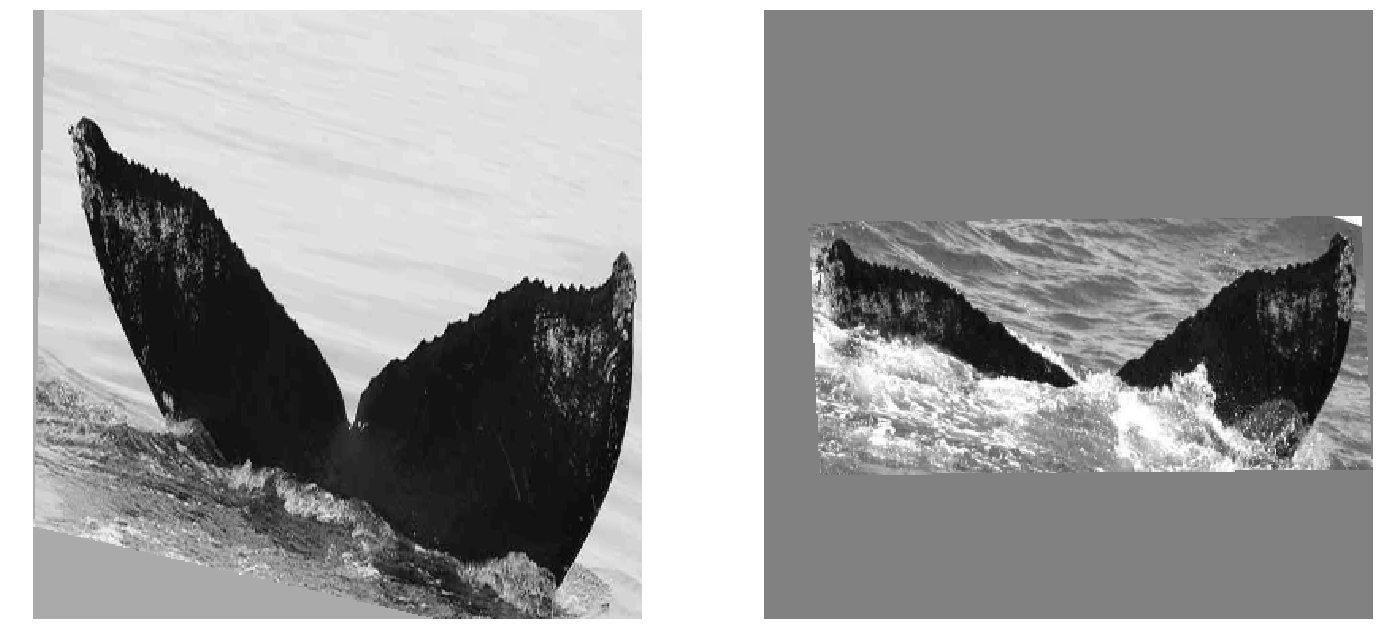

In [33]:
# First pair is for matching whale
imgs = [array_to_img(a[0]), array_to_img(b[0])]
show_whale(imgs, per_row=2)

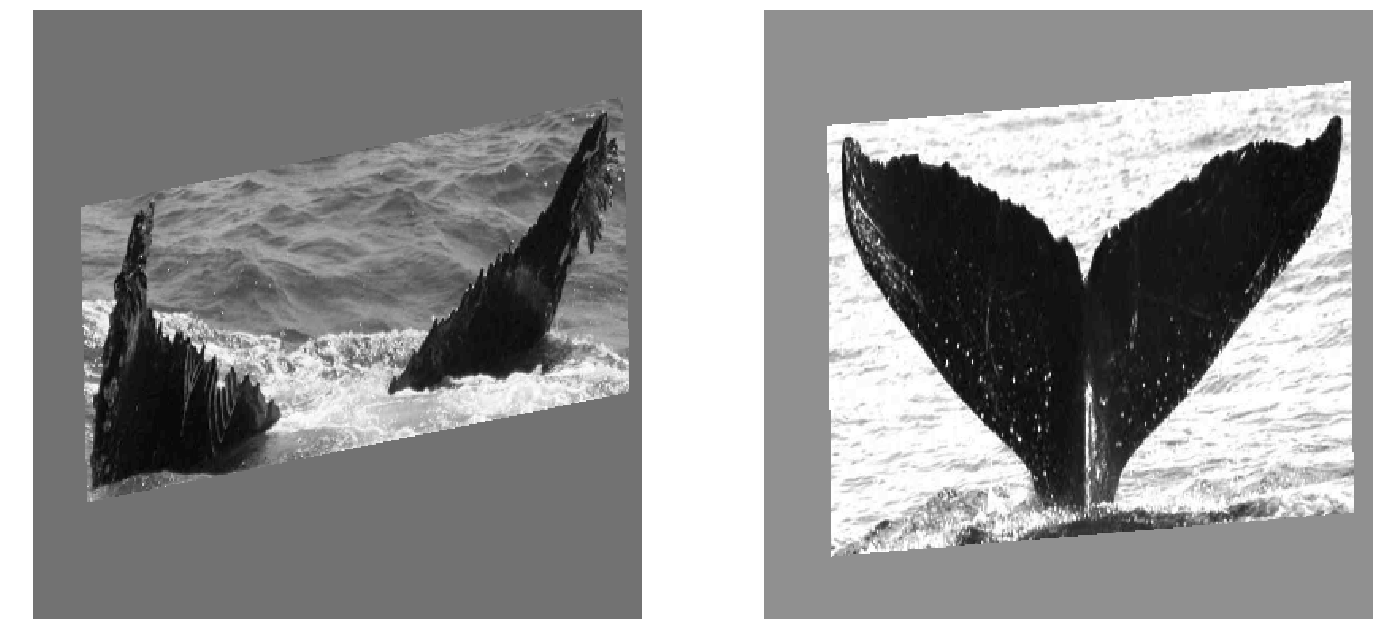

In [34]:
# Second pair is for different whales
imgs = [array_to_img(a[1]), array_to_img(b[1])]
show_whale(imgs, per_row=2)

# Training procedure
This scection describes the procedure used to train the model. Training lasts 400 epochs, with the following quantities changing as the training progresses:

* Learning rate
* L2 regularization
* Constant K measuring the scale of the random component of the score matrix used to match similar images to construct tough training cases.

The procedure itself has evolved from many previous experiments, trial and errors on earlier versions of the model.

Training the large model from random weights is difficult. In fact, if the model is initially fed examples that are too hard, it does not converge at all. In the context here, hard examples are similar images belonging to different whales. Pushed to the extreme, it it possible to construct a training dataset for which pairs of pictures of different whales appear (to the model) more similar than pairs of pictures from the same whale, making the model learn to classify similar images as different whales, and dissimilar images as same whales!

To prevent this, early training is executed with a large value of K, making the negative examples essentially random pairs of pictures of different whales. As the model ability to distinguish between whales increases, K is gradually reduced, presenting harder training cases. Similarly, training starts with no L2 regularization. After 250 epochs, trainings accuracy is fantastic, but it also grossly overfits. At this point, L2 regularization is applied, learning rate is reset to a large value and training continues for an additional 150 epochs.

The following table shows the exact schedule used for the learning rate (LR), L2 regularization (L2) and randomized score matrix (K). 

Also note that the score matrix for the Linear Assignment Problem is computed at every 5 epochs starting with epoch 10.

Epochs | LR | K | L2
---- | ---: | ---: | ---:
1-10 | \\( 64.10^{-5} \\)  | \\( +\infty \\) | 0
11-15 | \\( 64.10^{-5} \\) | 100.00 | 0
16-20 | \\( 64.10^{-5} \\) | 63.10 | 0
21-25 | \\( 64.10^{-5} \\) | 39.81 | 0
26-30 | \\( 64.10^{-5} \\) | 25.12 | 0
31-35 | \\( 64.10^{-5} \\) | 15.85 | 0
36-40 | \\( 64.10^{-5} \\) | 10.00 | 0
41-45 | \\( 64.10^{-5} \\) | 6.31 | 0
46-50 | \\( 64.10^{-5} \\) | 3.98 | 0
51-55 | \\( 64.10^{-5} \\) | 2.51 | 0
56-60 | \\( 64.10^{-5} \\) | 1.58 | 0
61-150 | \\( 64.10^{-5} \\) | 1.00 | 0
151-200 | \\( 16.10^{-5} \\) | 0.50 | 0
200-240 | \\( 4.10^{-5} \\) | 0.25 | 0
241-250 | \\( 10^{-5} \\) | 0.25 | 0
251-300 | \\( 64.10^{-5} \\) | 1.00 | \\( 2.10^{-4} \\)
301-350 | \\( 16.10^{-5} \\) | 0.50 | \\( 2.10^{-4} \\)
351-390 | \\( 4.10^{-5} \\) | 0.25 | \\( 2.10^{-4} \\)
391-400 | \\( 10^{-5} \\) | 0.25 | \\( 2.10^{-4} \\)



In [35]:
# A Keras generator to evaluate only the BRANCH MODEL
class FeatureGen(Sequence):
    def __init__(self, data, batch_size=64, verbose=1):
        super(FeatureGen, self).__init__()
        self.data       = data
        self.batch_size = batch_size
        self.verbose    = verbose
        if self.verbose > 0: self.progress = tqdm_notebook(total=len(self), desc='Features')
    def __getitem__(self, index):
        start = self.batch_size*index
        size  = min(len(self.data) - start, self.batch_size)
        a     = np.zeros((size,) + img_shape, dtype=K.floatx())
        for i in range(size): a[i,:,:,:] = read_for_validation(self.data[start + i])
        if self.verbose > 0: 
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return a
    def __len__(self):
        return (len(self.data) + self.batch_size - 1)//self.batch_size

# A Keras generator to evaluate on the HEAD MODEL on features already pre-computed.
# It computes only the upper triangular matrix of the cost matrix if y is None.
class ScoreGen(Sequence):
    def __init__(self, x, y=None, batch_size=2048, verbose=1):
        super(ScoreGen, self).__init__()
        self.x          = x
        self.y          = y
        self.batch_size = batch_size
        self.verbose    = verbose
        if y is None:
            self.y           = self.x
            self.ix, self.iy = np.triu_indices(x.shape[0],1)
        else:
            self.iy, self.ix = np.indices((y.shape[0],x.shape[0]))
            self.ix          = self.ix.reshape((self.ix.size,))
            self.iy          = self.iy.reshape((self.iy.size,))
        self.subbatch = (len(self.x) + self.batch_size - 1)//self.batch_size
        if self.verbose > 0: self.progress = tqdm_notebook(total=len(self), desc='Scores')
    def __getitem__(self, index):
        start = index*self.batch_size
        end   = min(start + self.batch_size, len(self.ix))
        a     = self.y[self.iy[start:end],:]
        b     = self.x[self.ix[start:end],:]
        if self.verbose > 0: 
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return [a,b]
    def __len__(self):
        return (len(self.ix) + self.batch_size - 1)//self.batch_size

In [37]:
pip install keras-tqdm

Note: you may need to restart the kernel to use updated packages.


In [38]:
from keras_tqdm import TQDMNotebookCallback

def set_lr(model, lr):
    K.set_value(model.optimizer.lr, float(lr))

def get_lr(model):
    return K.get_value(model.optimizer.lr)

def score_reshape(score, x, y=None):
    """
    Tranformed the packed matrix 'score' into a square matrix.
    @param score the packed matrix
    @param x the first image feature tensor
    @param y the second image feature tensor if different from x
    @result the square matrix
    """
    if y is None:
        # When y is None, score is a packed upper triangular matrix.
        # Unpack, and transpose to form the symmetrical lower triangular matrix.
        m = np.zeros((x.shape[0],x.shape[0]), dtype=K.floatx())
        m[np.triu_indices(x.shape[0],1)] = score.squeeze()
        m += m.transpose()
    else:
        m        = np.zeros((y.shape[0],x.shape[0]), dtype=K.floatx())
        iy,ix    = np.indices((y.shape[0],x.shape[0]))
        ix       = ix.reshape((ix.size,))
        iy       = iy.reshape((iy.size,))
        m[iy,ix] = score.squeeze()
    return m

def compute_score(verbose=1):
    """
    Compute the score matrix by scoring every pictures from the training set against every other picture O(n^2).
    """
    features = branch_model.predict_generator(FeatureGen(train, verbose=verbose), max_queue_size=12, workers=6, verbose=0)
    score    = head_model.predict_generator(ScoreGen(features, verbose=verbose), max_queue_size=12, workers=6, verbose=0)
    score    = score_reshape(score, features)
    return features, score

def make_steps(step, ampl):
    """
    Perform training epochs
    @param step Number of epochs to perform
    @param ampl the K, the randomized component of the score matrix.
    """
    global w2ts, t2i, steps, features, score, histories
    
    # shuffle the training pictures
    random.shuffle(train)
    
    # Map whale id to the list of associated training picture hash value
    w2ts = {}
    for w,hs in w2hs.items():
        for h in hs:
            if h in train_set:
                if w not in w2ts: w2ts[w] = []
                if h not in w2ts[w]: w2ts[w].append(h)
    for w,ts in w2ts.items(): w2ts[w] = np.array(ts)

    # Map training picture hash value to index in 'train' array    
    t2i  = {}
    for i,t in enumerate(train): t2i[t] = i    

    # Compute the match score for each picture pair
    features, score = compute_score()
    
    # Train the model for 'step' epochs
    history = model.fit_generator(
        TrainingData(score + ampl*np.random.random_sample(size=score.shape), steps=step, batch_size=32),
        initial_epoch=steps, epochs=steps + step, max_queue_size=12, workers=6, verbose=0,
        callbacks=[
            TQDMNotebookCallback(leave_inner=True, metric_format='{value:0.3f}')
        ]).history
    steps += step
    
    # Collect history data
    history['epochs'] = steps
    history['ms'    ] = np.mean(score)
    history['lr'    ] = get_lr(model)
    print(history['epochs'],history['lr'],history['ms'])
    histories.append(history)

In [39]:
model_name = 'mpiotte-standard'
histories  = []
steps      = 0

In [40]:
if isfile('./humpback-whale-identification-model-files/mpiotte-standard.model'):
    tmp = keras.models.load_model('./humpback-whale-identification-model-files/mpiotte-standard.model')
    model.set_weights(tmp.get_weights())
else:
    # epoch -> 10
    make_steps(10, 1000)
    ampl = 100.0
    for _ in range(10):
        print('noise ampl.  = ', ampl)
        make_steps(5, ampl)
        ampl = max(1.0, 100**-0.1*ampl)
    # epoch -> 150
    for _ in range(18): make_steps(5, 1.0)
    # epoch -> 200
    set_lr(model, 16e-5)
    for _ in range(10): make_steps(5, 0.5)
    # epoch -> 240
    set_lr(model, 4e-5)
    for _ in range(8): make_steps(5, 0.25)
    # epoch -> 250
    set_lr(model, 1e-5)
    for _ in range(2): make_steps(5, 0.25)
    # epoch -> 300
    weights = model.get_weights()
    model, branch_model, head_model = build_model(64e-5,0.0002)
    model.set_weights(weights)
    for _ in range(10): make_steps(5, 1.0)
    # epoch -> 350
    set_lr(model, 16e-5)
    for _ in range(10): make_steps(5, 0.5)    
    # epoch -> 390
    set_lr(model, 4e-5)
    for _ in range(8): make_steps(5, 0.25)
    # epoch -> 400
    set_lr(model, 1e-5)
    for _ in range(2): make_steps(5, 0.25)
    model.save('mpiotte-standard.model')

#  Generating the submission file
The basic strategy is this. For each picture from the test set:

1. If the image duplicates one or more training set images, add the whales (possibly more than one) from the training image as the top candidates.
1. For each image not new_whale from the training set, compute the image score, which is the model score for the image pair.
1. For each whale from the training set, compute the whale score as the maximum image score for this whale.
1. Add new_whale with a fixed new whale score of 'threshold'.
1. Sort the whales in decreasing score.

Duplicate image are free answers, assuming there is no tagging error. For new_whale, the algorithm will chose high confidence prediction first, then insert new_whale, then low confidence predictions. 'threshold' is selected through trial and error, although most model variants perform best with a value of 'threshold' that results in ~7100 test images with new_whale as first choice, something that can be measured without submitting a prediction to Kaggle.

In [41]:
# Not computing the submission in this notebook because it is a little slow. It takes about 15 minutes on setup with a GTX 1080.
import gzip

def prepare_submission(threshold, filename):
    """
    Generate a Kaggle submission file.
    @param threshold the score given to 'new_whale'
    @param filename the submission file name
    """
    vtop  = 0
    vhigh = 0
    pos   = [0,0,0,0,0,0]
    with gzip.open(filename, 'wt', newline='\n') as f:
        f.write('Image,Id\n')
        for i,p in enumerate(tqdm_notebook(submit)):
            t = []
            s = set()
            a = score[i,:]
            for j in list(reversed(np.argsort(a))):
                h = known[j]
                if a[j] < threshold and new_whale not in s:
                    pos[len(t)] += 1
                    s.add(new_whale)
                    t.append(new_whale)
                    if len(t) == 5: break;
                for w in h2ws[h]:
                    assert w != new_whale
                    if w not in s:
                        if a[j] > 1.0:
                            vtop += 1
                        elif a[j] >= threshold:
                            vhigh += 1
                        s.add(w)
                        t.append(w)
                        if len(t) == 5: break;
                if len(t) == 5: break;
            if new_whale not in s: pos[5] += 1
            assert len(t) == 5 and len(s) == 5
            f.write(p + ',' + ' '.join(t[:5]) + '\n')
    return vtop,vhigh,pos

if False:
    # Find elements from training sets not 'new_whale'
    h2ws = {}
    for p,w in tagged.items():
        if w != new_whale: # Use only identified whales
            h = p2h[p]
            if h not in h2ws: h2ws[h] = []
            if w not in h2ws[h]: h2ws[h].append(w)
    known = sorted(list(h2ws.keys()))

    # Dictionary of picture indices
    h2i   = {}
    for i,h in enumerate(known): h2i[h] = i

    # Evaluate the model.
    fknown  = branch_model.predict_generator(FeatureGen(known), max_queue_size=20, workers=10, verbose=0)
    fsubmit = branch_model.predict_generator(FeatureGen(submit), max_queue_size=20, workers=10, verbose=0)
    score   = head_model.predict_generator(ScoreGen(fknown, fsubmit), max_queue_size=20, workers=10, verbose=0)
    score   = score_reshape(score, fknown, fsubmit)

    # Generate the subsmission file.
    prepare_submission(0.99, 'mpiotte-standard.csv.gz')

# Bootstrapping and ensemble
The mpiotte-standard.model is good for a 0.766 score.

Because the training data set is small, and the test set is larger, bootstrapping is a good candidate to improve the score. In this context, bootstrapping means using the model to automatically generate additional training example, and retrained the model over this larger dataset. For this experiment, I selected all images from the test set for which the mpiotte-standard model provides a single whale prediction with a score > 0.999999 (score is just a number use to rank whales, it is **not** a probability).  

## Bootstrapping

In [42]:
with open('./humpback-whale-identification-model-files/bootstrap.pickle', 'rb') as f:
    bootstrap = pickle.load(f)
len(bootstrap), list(bootstrap.items())[:5]

(1885,
 [('ea8f94e03ced18d2', 'w_0b775c1'),
  ('bd84d2b265199e65', 'w_e8bce8a'),
  ('afdad0a5e024bd23', 'w_3461d6d'),
  ('b61cc9598e4fea12', 'w_34c8690'),
  ('a1be8e613c8c5379', 'w_7554f44')])

Submitting these 1885 pictures as a submission show that this set if over 93% accurate.

Adding these files to the training set and re-running the training from scratch generates the mpiotte.bootstrap.model, also included in the dataset. This model as a slightly better score of 0.744 with a threshold=0.989.

## Ensemble

The best score is obtained by an ensemble of the mpiotte-standard.model and mpiotte-bootstrap.model. Both of these models make different errors because of their nature, which make them good candidate for ensembling:

* The standard model is trained on the smallest training set, and thus has more potential for overfitting.
* The bootstrap model is trained on more data, however the tagging accuracy is lower since the bootstrap data is only 93% accurate.

The assembly strategy consist in compute a score matrix (or dimension test by train) that is a linear combination of the standard and bootstrap model. Generation of the submission using the score matrix is unchanged. Trial and error suggest a weight of 0.45 for the standard model and 0.55 for the bootstrap model.

The resulting ensemble as an accuracy of **0.78563** using a threshold of 0.92. It is interesting to note how the 'threshold' value for the ensemble is much lower, which is consistent with the fact that both models make different errors, and thus the ensemble scores are typically lower than the individual models, which are grossly optimistic about they guesses.

# Visualization
This section explores the model through some visualizations.

## Feature weights

As was discussed in the model description, the head model makes a weighted sum of the features, allowing for negative weights. We can verify that we see a combination of positive and negative weights, that confirm that some features, when matched, reduce the probability of matching whales. This could be that we match uniform, unicolor flukes, which is less likely to be correct that mathing flukes with multiple caracteristic markings.

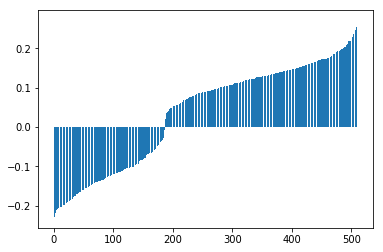

In [43]:
w = head_model.layers[-1].get_weights()[0]
w = w.flatten().tolist()
w = sorted(w)
fig, axes = plt.subplots(1,1)
axes.bar(range(len(w)), w)
plt.show()

We can also check how 'per feature' network behave for different feature values.

What we expect to see is that equal zero feature should produce a smaller output than similar large values. At the same time, very dissimilar values must be penalized.

In [44]:
# Construct the head model with linear activation
_, _, tmp_model = build_model(64e-5,0, activation='linear')
tmp_model.set_weights(head_model.get_weights())

In [45]:
# Evaluate the model for constant vectors.
a = np.ones((21*21,512),dtype=K.floatx())
b = np.ones((21*21,512),dtype=K.floatx())
for i in range(21):
    for j in range(21):
        a[21*i + j] *= float(i)/10.0
        b[21*i + j] *= float(j)/10.0
x    = np.arange(0.0, 2.01, 0.1, dtype=K.floatx())
x, y = np.meshgrid(x, x)
z    = tmp_model.predict([a,b], verbose=0).reshape((21,21))
x.shape, y.shape, z.shape

((21, 21), (21, 21), (21, 21))

## Pseudo-distance function

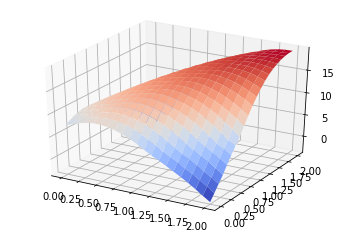

In [46]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap=cm.coolwarm)
plt.show()

Not very easy to see, but still the largest output (best whale match) occurs for matching features with large values. Matching zeros get llower value.

Just the colormap is probably easier to see. This confirms are initial assumptions.

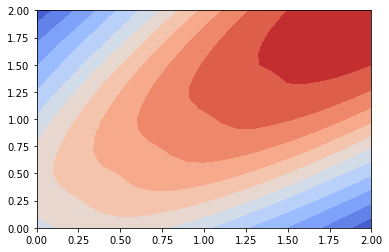

In [47]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

levels = MaxNLocator(nbins=15).tick_values(z.min(), z.max())
fig = plt.figure()
ax = fig.add_subplot(111)
cf = ax.contourf(x, y, z, levels=levels, cmap=cm.coolwarm)
plt.show()

## Feature activation
This section attempts to reconstruct image that maximally activate a feature. This provides some insight on the filtering process.

The code to generate images is modified from examples found in [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) by Francois Chollet.

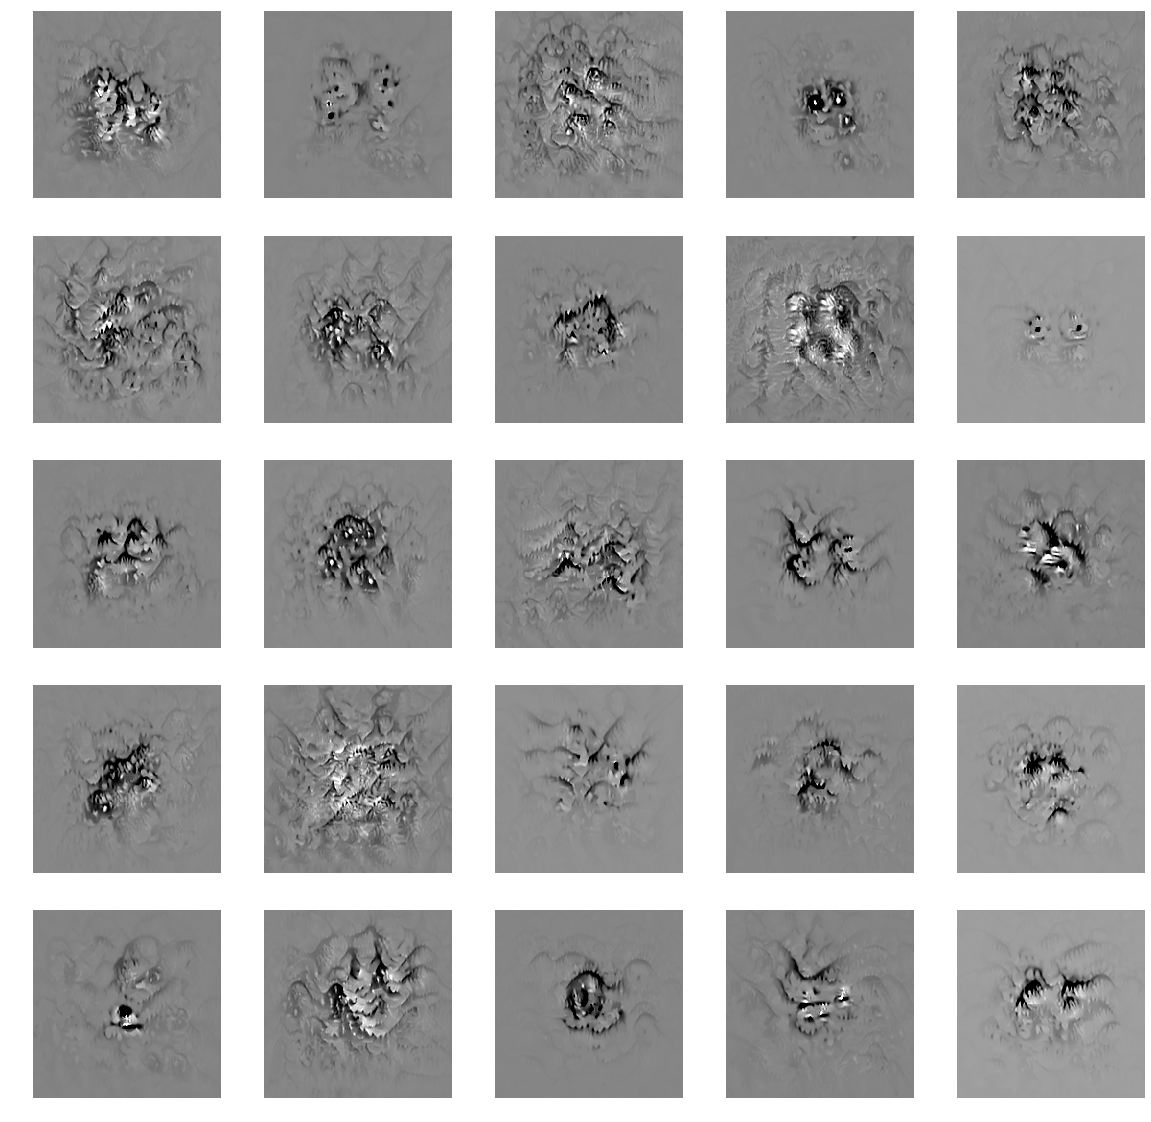

In [48]:
from scipy.ndimage import gaussian_filter

def show_filter(filter, blur):
    np.random.seed(1)
    noise   = 0.1 # Initial noise
    step    = 1 # Gradient step
    
    # Construct the function
    inp     = branch_model.layers[0].get_input_at(0)
    loss    = K.mean(branch_model.layers[-3].output[0,2:4,2:4,filter]) # Stimulate the 4 central cells
    grads   = K.gradients(loss, inp)[0]
    grads  /= K.sqrt(K.mean(K.square(grads))) + K.epsilon()
    iterate = K.function([inp],[grads])
    img     = (np.random.random(img_shape) -0.5)*noise
    img     = np.expand_dims(img, 0)

    # Use gradient descent to form image
    for i in range(200):
        grads_value = iterate([img])[0]
        # Blurring a little creates nicer images by reducing reconstruction noise
        img = gaussian_filter(img + grads_value*step, sigma=blur)

    # Clip the image to improve contrast
    avg  = np.mean(img)
    std  = sqrt(np.mean((img - avg)**2))
    low  = avg - 5*std
    high = avg + 5*std
    return array_to_img(np.minimum(high, np.maximum(low, img))[0])

# Show the first 25 features (of 512)
show_whale([show_filter(i, 0.5) for i in tqdm_notebook(range(25))], per_row=5)

# Off topic

## Training Scalability
As described, training the base model takes about 2 days, and the bootstrap version a little under 3 days, using a i7-8700 CPU and GTX 1080 GPU. More than 50% of the time is spent solving the Linear Assignment Problem because the algorithm used has complexity \\( O(n^3) \\) and provides an exact solution. However, the score matrix is randomized, so investing a lot of time to compute an exact solution to a randomized input is wasteful. In the context of this competition, with no constraint on runtime and a small dataset, it was a pragmatic choice. However, to scale this approach, a less costly randomized matching heuristic would be more effective.

Another approach to training scalability would be to partition the training data into different subset, each subset being processed separately to match image pairs. The subset can be reconstructed randomly each time the cost matrix is computed. This would be effective not only for the Linear Assignment Problem part, but also when computing the cost matrix, which still has complexity \\( O(n^2) \\). By fixing the subset size to a reasonable value, the complexity then grows linearly with the number of subsets, allowing larger training datasets..  

## Interesting results and scores
Score | Description
---:|-------
0.786 | best score obtained by a linear combination of the standard model with the bootstrap model
0.774 | bootstrapped model
0.766 | standard model
0.752 | VGG like CNN, trained like standard model
0.728 | standard model without L2 regularization (result after 250 epochs)
0.714 | standard model without exclusion list, rotation list and bounding box model (i.e. no manual judgement on the training set)
0.423 | duplicate images and new_whale submission
0.325 | new_whale submission
0.107 | duplicate images only


## Validation set
I have not discussed validation data until now. During development, I used a validation set composed of 570 images from the training set to test ideas and to tune the training procedure. However, greater accuracy can be achieved by retraining the model using all the data,  repeating he procedure that was successful on the validation set. This notebook essentially describes this final retraining, and thus there is no validation set involved.